# Advanced ML: Домашнее задание 3

In [17]:
import pickle
import pandas as pd
from datetime import timedelta, datetime
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy.stats import norm
from copy import copy
import scipy.stats as sts
from scipy.special import expit as sigmoid

### 1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). 

In [18]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))
players_ = pickle.load(open('data/players.pkl', 'rb'))

In [19]:
#tournaments_train = {key: value for key, value in tournaments.items() if value['dateStart'][:4] == '2019'}
#tournaments_test = {key: value for key, value in tournaments.items() if value['dateStart'][:4] == '2020'}

In [20]:
#pickle.dump(tournaments_train, open('data/tournaments_train.pkl', 'wb'))
#pickle.dump(tournaments_test, open('data/tournaments_test.pkl', 'wb'))

In [21]:
print ('Объем выборок, соответственно',len(tournaments_train),' и ',len(tournaments_test), 'без предобработки.')


Объем выборок, соответственно 604  и  156 без предобработки.


In [22]:
tournaments_train = []
tournaments_test = []
for key in tournaments.keys():
    tournament_date = datetime.fromisoformat(tournaments[key]['dateStart']).replace(tzinfo=None)
    if tournament_date >= datetime.strptime('2019-01-01', '%Y-%m-%d'):
        if not results[key]:
            continue
        questions = set()
        for team in results[key]:
            if team.get('mask') is not None:
                questions.add(len(team['mask']))
        if len(questions) > 1:
            continue
        tournament = dict()
        tournament['id'] = tournaments[key]['id']
        tournament['teams'] = []
        for team in results[key]:
            # уберем случаи, когда маска пустая или в маске есть что-то кроме 0 и 1
            if team.get('mask') is None or team.get('mask').replace('0', '').replace('1', ''):
                # print(team)
                continue
            team_dict = dict()
            team_dict['id'] = team['team']['id']
            team_dict['mask'] = team['mask']
            team_dict['members'] = []
            for member in team['teamMembers']:
                player_id = member['player']['id']
                team_dict['members'].append(player_id)
            tournament['teams'].append(team_dict)
        if not tournament['teams']:
            continue
        if tournament_date < datetime.strptime('2020-01-01', '%Y-%m-%d'):
            tournaments_train.append(tournament)
        else:
            tournaments_test.append(tournament)

In [23]:
print ('Объем выборок стал, соответственно:',len(tournaments_train),len(tournaments_test))

Объем выборок стал, соответственно: 604 156


In [24]:
#pickle.dump(tournaments_train, open('data/tournaments_train.pkl', 'wb'))
#pickle.dump(tournaments_test, open('data/tournaments_test.pkl', 'wb'))

In [25]:
counts = []
correct_counts = []
for tournament in tournaments_train:
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        questions_count = len(team_answers)
        correct_answers = sum(team_answers)         
    counts.append(questions_count)
    correct_counts.append(correct_answers)

Text(0.5, 1.0, 'Число вопросов в турнирах')

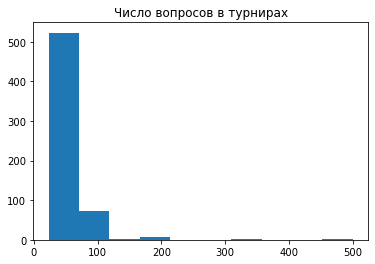

In [26]:
plt.hist(counts)
plt.title('Число вопросов в турнирах')

Text(0.5, 1.0, 'Число правильных ответов в турнирах')

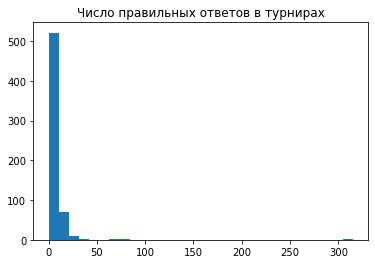

In [27]:
plt.hist(correct_counts,bins = 30)
plt.title('Число правильных ответов в турнирах')

Text(0.5, 1.0, 'Доля правильных ответов в турнирах')

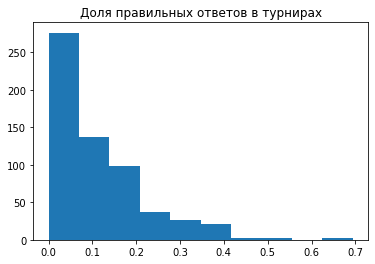

In [28]:
plt.hist(np.array(correct_counts) / np.array(counts))
plt.title('Доля правильных ответов в турнирах')
#Порепрезентативнее предыдущего графика

### 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. 

Изначально, вижу две базовые идеи - использовать OHE(dummy-переменные по сути) или ввести метрику "сложнонсти" вопроса.
В первом случае все тривиально, но количество потенциальных параметров пугает. Однако, для каждого примера в данных вектор будет очень разреженным, так как, на сколько я понимаю, не шибко сильно игроки любят отвечать на вопросы... Если расчеты не крашнутся, то должно получиться сносно. Ньютон, конечно, не осилит, но lbfgs должен быстро отработать.
Во втором случае в качестве метрики сложности можно, например, выбрать долю игроков, верно ответивших на вопрос. Вот только проблема тут уже в том, что турниры отличаются по сложности и пуллом участвующиъ команд. В общем, тут еще много таких "а еще ..."-моментов. Да и, вообще говоря, ответ на вопрос засчитывается команде, т.е. может засчитаться игроку, который даже в обсуждении не участвовал, поэтому это тоже влияет на отличие от реального "объективного" рейтинга именно игроков. Но тут уже какие данные имеем, с такими и работаем.

In [29]:
def prepare_data(tournaments_train):
    players_idxs = []
    question_idxs = []
    team_idxs = []
    tournament_idxs = []
    results = []
    players_questions_count = []
    players = set()
    players_answers = defaultdict(int)
    players_correct_answers = defaultdict(int)
    players_tours = defaultdict(int)
    questions_count = 0
    for tournament in tournaments_train:
        tournament_answers = []
        for team in tournament['teams']:
            for member in team['members']:
                players_answers[member] += len(team['mask'])
                players_correct_answers[member] = np.sum(np.array(map(int, team['mask'])))
                players_tours[member] += 1
                players.add(member)
    player_to_idx = {player: idx for idx, player in enumerate(players)}
    #idx_to_player = {idx: player for player, idx in player_to_idx.items()}
    for tournament in tournaments_train:
        tour_questions_count = len(tournament['teams'][0]['mask'])
        for team in tournament['teams']:
            team_answers = list(map(int, team['mask']))
            for i in range(tour_questions_count):
                for member in team['members']:
                    players_idxs.append(player_to_idx[member])
                    question_idxs.append(len(player_to_idx) + questions_count + i)
                    team_idxs.append(team['id'])
                    tournament_idxs.append(tournament['id'])
                    results.append(team_answers[i])
                    players_questions_count.append(players_answers[member])
        questions_count += tour_questions_count
    X = sparse.lil_matrix((len(players_idxs), len(player_to_idx) + questions_count), dtype=int)
    X[range(len(players_idxs)), players_idxs] = 1
    X[range(len(players_idxs)), question_idxs] = 1
    return X, results

In [30]:
X,y = prepare_data(tournaments_train)

In [31]:
X.shape

(13749583, 83415)

![ThinkingUrl](https://i.gifer.com/76EE.gif "Достойно....")

In [32]:
baseline_model = LogisticRegression(solver='lbfgs', n_jobs=-1, tol = 1e-3)

In [33]:
%%time
baseline_model.fit(X, np.array(y))

Wall time: 2min 10s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.001, verbose=0,
                   warm_start=False)

In [34]:
def build_rating():
    rating = []
    players = set()
    players_answers = defaultdict(int)
    players_correct_answers = defaultdict(int)
    players_tours = defaultdict(int)
    questions_count = 0
    for tournament in tournaments_train:
        tournament_answers = []
        for team in tournament['teams']:
            for member in team['members']:
                players_answers[member] += len(team['mask'])
                players_correct_answers[member] = np.sum(np.array(map(int, team['mask'])))
                players_tours[member] += 1
                players.add(member)
    player_to_idx = {player: idx for idx, player in enumerate(players)}
    idx_to_player = {idx: player for player, idx in player_to_idx.items()}    
    players_rating = baseline_model.coef_[0][:len(player_to_idx)]
    return [{'rating': players_rating[idx], 'id': player,
                    'name': players_[player]['name'] + ' ' + players_[player]['surname'],
                    'number of answers': players_answers[player]} for idx, player in idx_to_player.items()],baseline_model.coef_[0][len(player_to_idx):]

In [35]:
rating,q_rating = build_rating()

In [36]:
rating_df = pd.DataFrame(rating)

In [37]:
rating_df.head()

,rating,id,name,number of answers
0,1.014458,131077,Паруйр Аланакян,859
1,0.095152,131080,Иван Мешков,382
2,1.708891,131082,Валерия Кан,3454
3,1.552642,131083,Валерий Аввакумов,1013
4,0.294295,15,Олег Абарников,400


In [38]:
rating_df = rating_df.sort_values(by = ['rating'],ascending=False).reset_index()

In [39]:
rating_df.head()

,index,rating,id,name,number of answers
0,9346,3.812237,27403,Максим Руссо,1796
1,1409,3.558839,4270,Александра Брутер,2240
2,12939,3.428037,37047,Мария Юнгер,452
3,10322,3.397352,30152,Артём Сорожкин,4006
4,6910,3.318305,20691,Станислав Мереминский,1370


### 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
#### предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
#### в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Тут я, конечно, очень своевременно понял, что делать предикты для игроков, которых мы не видели в трейне, мы особо не может. В лучшем случае - будем считать таких "среднестатитическим" (еще нужно подумать, каким именно "средне"). Пожалуй, опущу их из тестовой выборки.

In [40]:
rating = []
players = set()
players_answers = defaultdict(int)
players_correct_answers = defaultdict(int)
players_tours = defaultdict(int)
questions_count = 0
for tournament in tournaments_train:
    tournament_answers = []
    for team in tournament['teams']:
        for member in team['members']:
            players_answers[member] += len(team['mask'])
            players_correct_answers[member] = np.sum(np.array(map(int, team['mask'])))
            players_tours[member] += 1
            players.add(member)
player_to_idx = {player: idx for idx, player in enumerate(players)}
idx_to_player = {idx: player for player, idx in player_to_idx.items()}  

In [41]:
tournaments_test_r = []
tournaments_rating_true = []
for tournament in tournaments_test:
    teams_test = []
    teams_rating = []
    for team in tournament['teams']:  
        valid_players = [member for member in team['members'] if member in player_to_idx.keys()]
        team_test = copy(team)
        team_test['members'] = valid_players        
        if len(valid_players) > 0:
            teams_test.append(team_test)
            team_answers = list(map(int, team['mask']))
            team_score = sum(team_answers)
            teams_rating.append(team_score)     
    if len(teams_test) > 1:
        tournament_test = copy(tournament)
        tournament_test['teams'] = teams_test
        tournaments_test_r.append(tournament_test)
        tournaments_rating_true.append(teams_rating)

Для того, чтобы ответ был зачтен игроку, достаточно, чтобы на вопрос ответил хотя бы один из членов команды. Но тут, конечно, мы получаем, будто за каждого игрока отвечают все члены его предыдущих команд... Ладно, что поделать. 
Нужно подумать, как поступить с вопросами и их сложностью. Предугадать сложность вопросов не можем, посмотрим на распределение сложности вопросов, которые были получены из модели.

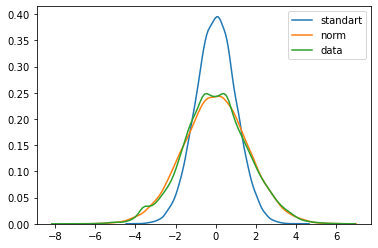

In [42]:
sns.distplot(norm.rvs(size=len(q_rating)),hist=False, kde=True,label = 'standart')
sns.distplot(norm.rvs(loc = np.mean(q_rating), scale = np.std(q_rating),size=len(q_rating)),hist=False, kde=True,label = 'norm')
sns.distplot(q_rating,hist=False, kde=True, label = 'data')
plt.show()

Похоже на нормальное с центром в 0. Хотя, есть два сомнительных пика, вопросы чуть посложнее и чуть попроще. Но склонен считать, что мы можем предположить, что у новых ваопросов будет "сложность" равная нулю, хотя, думаю, корректнее было бы сэмплировать вопросы из распределения. Но при этом, ибо вопросов в рамках одной игры ощутимо меньше, чем в истории игр, то это может привести к нежелательным выбросам. 

P.S. Знаете, мне кажется это, на самом деле, занимательный филосовский момент. Получается, есть какие-то вопросы средней сложности, вне зависимости от предметной области вопроса. То есть у составителей (да и вообще людей) есть ощущение этой "средней сложности". Ну или просто так же используются исторические данные ответов на вопросы и вопросы повторяются... но это не так романтично звучит. А еще менее романтично звучит то, что это все может быть из-за регуляризации.

In [43]:
tournaments_rating_pred = []
for comp in tournaments_test_r:
    tournament_questions_count = len(comp['teams'][0]['mask'])
    preds = []
    for team in comp['teams']:
        players_idxs = [player_to_idx[player] for player in team['members']]
        players_count = len(players_idxs)
        X_test = sparse.lil_matrix((players_count, X.shape[1]), dtype=int)
        X_test[range(len(players_idxs)), players_idxs] = 1
        preds.append(1 - (baseline_model.predict_proba(X_test)[:, 0]).prod())
        #предиктим, что никто не ответим, вычитаем, получаем p, что хотя бы один ответит.
    tournaments_rating_pred.append(preds)

In [44]:
spearmanr_corrs = [sts.spearmanr(a, b).correlation for a,b in zip(tournaments_rating_true, tournaments_rating_pred)]
kendall_corrs = [sts.kendalltau(a, b).correlation for a,b in zip(tournaments_rating_true, tournaments_rating_pred)]

In [45]:
print('Spearman\'s rank:', np.mean(spearmanr_corrs))
print('Kendall\'s rank:',np.mean(kendall_corrs))

Spearman's rank: 0.7731874781451625
Kendall's rank: 0.6160696360689951


### 4.	Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
○	предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;

○	разработайте EM-схему для обучения этой модели, реализуйте её в коде;

○	обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Введем новую переменную, которая будет отвечать за вероятность ответить на вопрос при услови того или иного состава команды. В данном случае придется сделать наивное предположение, что если ответ не был дан, то никто из игроков не знал ответ на вопрос, хотя, очевидно, что просто напросто при обсуждении верный ответ мог быть отвергнут. Но, как мне кажется, предположение не самое плохое, ведь мы пытаемся ответить на вопрос, ответит ли команда на вопрос или нет, а не знает ли команда ответ на вопрос. По сути, тут зашита некоторая оценка качества decision-making процесса при ответе на вопрос. 

Пусть событие $A_t$ - команда t верно ответила на вопрос, а событие  $A_p$ - игрок p ответил на вопрос, тогда:

$$P(A_p|A_t) = \frac{P(A_t)}{P(A_p)}$$

Будем искать эту вероятность на Е-шаге. А на M-шаге будем обучать модель на результатах E-шага, максимизируя правдоподобие.

In [102]:
def e_step(X,w):
    preds = sigmoid((sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])).dot(w))
    return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))

In [111]:
def m_step(X,y,w,rate,iters):
    X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X])          
    losses = []
    prev_mean_loss = np.inf        
    data_len = X.shape[0]        
    for i in range(iters):
        batch_idxs = np.random.choice(data_len, batch_size)
        X_batch = X[batch_idxs, :]
        y_batch = y[batch_idxs]
        preds = sigmoid(X_batch.dot(w))
        losses.append(log_loss(y_batch, preds))
        if (i + 1) % (iters/10) == 0:
            new_mean_loss = np.mean(losses)
            if (prev_mean_loss - new_mean_loss) < 1e-3:
                print('Loss:',new_mean_loss)
                break                    
            losses = []
            prev_mean_loss = new_mean_loss
        grad = -X_batch.T.dot(y_batch - preds) / len(y_batch)
        w -= rate * grad 
        

In [109]:
def calc_z():
    df_team = pd.DataFrame({'team': team_idxs, 'question': question_idxs, 'false': preds[:, 0], 'Ap': preds[:, 1]})
    df_team_ = df_team.groupby(['team', 'question']).agg({'false': 'prod'}).reset_index()
    df_team_['At'] = 1 - df_team_['fail\']
    df_team = pd.merge(df_team, df_team_, left_on=['team', 'question'],  right_on=['team', 'question'])
    returne (df_team['Ap'] / df_team['At']).clip(0, 1)

In [74]:
y = np.array(results)

In [79]:
def log_loss(y, p):
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [113]:
max_iters=20
iters=500
rate = 1
batch_size=500
w = np.hstack((baseline_model.intercept_, baseline_model.coef_[0]))#w = np.random.normal(size=X_test.shape[1]+1)
players_idxs = []
question_idxs = []
team_idxs = []
tournament_idxs = []
results = []
players_questions_count = []
players = set()
players_answers = defaultdict(int)
players_correct_answers = defaultdict(int)
players_tours = defaultdict(int)
questions_count = 0
for tournament in tournaments_train:
    tournament_answers = []
    for team in tournament['teams']:
        for member in team['members']:
            players_answers[member] += len(team['mask'])
            players_correct_answers[member] = np.sum(np.array(map(int, team['mask'])))
            players_tours[member] += 1
            players.add(member)
player_to_idx = {player: idx for idx, player in enumerate(players)}
idx_to_player = {idx: player for player, idx in player_to_idx.items()}
for tournament in tournaments_train:
    tour_questions_count = len(tournament['teams'][0]['mask'])
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        for i in range(tour_questions_count):
            for member in team['members']:
                players_idxs.append(player_to_idx[member])
                question_idxs.append(len(player_to_idx) + questions_count + i)
                team_idxs.append(team['id'])
                tournament_idxs.append(tournament['id'])
                results.append(team_answers[i])
                players_questions_count.append(players_answers[member])
    questions_count += tour_questions_count
X = sparse.lil_matrix((len(players_idxs), len(player_to_idx) + questions_count), dtype=int)
X[range(len(players_idxs)), players_idxs] = 1
X[range(len(players_idxs)), question_idxs] = 1
for i in range(max_iters):    
    preds = e_step(X,w)
    z = calc_z()    
    z[y == 0] = 0        
    m_step(X, z,w,rate,iters)
    tournaments_rating_pred = []
    for comp in tournaments_test_r:
        tournament_questions_count = len(comp['teams'][0]['mask'])
        preds = []
        for team in comp['teams']:
            players_idxs = [player_to_idx[player] for player in team['members']]
            players_count = len(players_idxs)
            X_test = sparse.lil_matrix((players_count, X_test.shape[1]), dtype=int)
            X_test[range(len(players_idxs)), players_idxs] = 1
            preds.append(1 - (e_step(X_test,w)[:, 0]).prod())
        tournaments_rating_pred.append(preds)
spearmanr_corrs = [sts.spearmanr(a, b).correlation for a,b in zip(tournaments_rating_true, tournaments_rating_pred)]
kendall_corrs = [sts.kendalltau(a, b).correlation for a,b in zip(tournaments_rating_true, tournaments_rating_pred)]
print('Spearman\'s rank:', np.mean(spearmanr_corrs))
print('Kendall\'s rank:',np.mean(kendall_corrs))

Loss: 0.38099930862808057
Loss: 0.35105123724912135
Loss: 0.33542742715073304
Loss: 0.3250741752948015
Loss: 0.3195358385498308
Loss: 0.31940014451306487
Loss: 0.3170564123370652
Loss: 0.3170743160563409
Loss: 0.316363228276575
Loss: 0.31755539062800237
Loss: 0.3168416654266888
Loss: 0.3141230541494996
Loss: 0.31804824240742424
Loss: 0.31553221544575594
Loss: 0.31647558567279327
Loss: 0.31687918282165756
Loss: 0.31220296545367443
Loss: 0.3159983359466818
Loss: 0.31253854611538073
Loss: 0.3173187808420288
Spearman's rank: 0.7791916192884468
Kendall's rank: 0.6235945350429238


In [114]:
pickle.dump(w, open('data/ws.pkl', 'wb'))

In [115]:
def build_new_rating():
    rating = []
    players = set()
    players_answers = defaultdict(int)
    players_correct_answers = defaultdict(int)
    players_tours = defaultdict(int)
    questions_count = 0
    for tournament in tournaments_train:
        tournament_answers = []
        for team in tournament['teams']:
            for member in team['members']:
                players_answers[member] += len(team['mask'])
                players_correct_answers[member] = np.sum(np.array(map(int, team['mask'])))
                players_tours[member] += 1
                players.add(member)
    player_to_idx = {player: idx for idx, player in enumerate(players)}
    idx_to_player = {idx: player for player, idx in player_to_idx.items()}    
    question_rating = w[len(player_to_idx) + 1:]
    players_rating = w[:len(player_to_idx) +1]
    return [{'rating': players_rating[idx], 'id': player,
                    'name': players_[player]['name'] + ' ' + players_[player]['surname'],
                    'number of answers': players_answers[player]} for idx, player in idx_to_player.items()]

In [116]:
new_rating = build_new_rating()

In [117]:
new_rating_df = pd.DataFrame(new_rating)

In [120]:
new_rating_df = new_rating_df.sort_values(by = ['rating'],ascending=False).reset_index()

In [121]:
new_rating_df

,index,rating,id,name,number of answers
0,9347,3.811192,27404,Екатерина Лукьянцева,72
1,1410,3.559392,4271,Леонид Брухис,678
2,12940,3.424895,37048,Кирилл Юнёв,516
3,10323,3.410792,30160,Александр Сорокин,72
4,6911,3.318432,20692,Виктор Меренков,156
...,...,...,...,...,...
55146,25312,-2.613569,192676,Алёна Разина,108
55147,39421,-2.616600,207831,Иван Козлов,225
55148,19973,-2.640004,184712,Валерия Зеленина,36
55149,12870,-2.705690,167953,Айдос Асхатулы,543


In [122]:
delta = rating_df['rating'] - new_rating_df['rating']

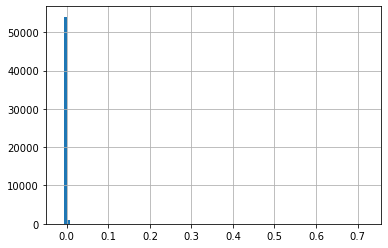

In [126]:
delta.hist(bins = 100)

In [134]:
deltas =[]
for id in rating_df['id']:
    deltas.append(list(rating_df.index[rating_df['id']==id])[0]-list(new_rating_df.index[new_rating_df['id']==id])[0])

In [136]:
rating_df

,index,rating,id,name,number of answers
0,9346,3.812237,27403,Максим Руссо,1796
1,1409,3.558839,4270,Александра Брутер,2240
2,12939,3.428037,37047,Мария Юнгер,452
3,10322,3.397352,30152,Артём Сорожкин,4006
4,6910,3.318305,20691,Станислав Мереминский,1370
...,...,...,...,...,...
55146,39421,-2.596473,207831,Иван Козлов,225
55147,25311,-2.613881,192675,Савелий Мезенцев,216
55148,39420,-2.616560,207830,Елисей Давлетбаков,261
55149,19972,-2.639792,184711,Ксения Низовских,297


(array([  158.,   438.,   710.,   960.,  1418.,  1855.,  2389.,  3202.,
         4347.,  7141., 16819.,  4469.,  3347.,  2486.,  1852.,  1340.,
          949.,   693.,   422.,   156.]),
 array([-5.49370e+04, -4.94462e+04, -4.39554e+04, -3.84646e+04,
        -3.29738e+04, -2.74830e+04, -2.19922e+04, -1.65014e+04,
        -1.10106e+04, -5.51980e+03, -2.90000e+01,  5.46180e+03,
         1.09526e+04,  1.64434e+04,  2.19342e+04,  2.74250e+04,
         3.29158e+04,  3.84066e+04,  4.38974e+04,  4.93882e+04,
         5.48790e+04]),
 <a list of 20 Patch objects>)

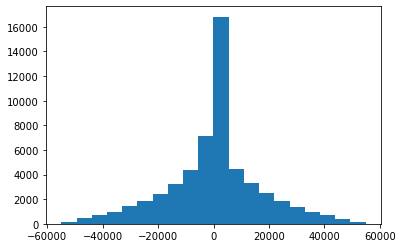

In [140]:
plt.hist(deltas,bins = 20)

Можно заметить, что произошло небольшое смещение рейтингов, которое поспособтвовало улучшению метрик.

In [142]:
rating_df[rating_df['name']=='Сергей Николенко']

,index,rating,id,name,number of answers
20,7671,3.102352,22799,Сергей Николенко,1806


In [144]:
new_rating_df[new_rating_df['name']=='Сергей Николенко']

,index,rating,id,name,number of answers
1113,7671,1.908715,22799,Сергей Николенко,1806


Грустная скобка.

Увы, по обстоятельствам до дедлайна успел только до этого места. Но хочется доделать всю остальную часть, поэтому если Вы это читаете, и дальше что-то есть в ноутбуке - это было добавлено уже после дедлайна, не знаю, какая система штрафов, но буду признателен, если посмотрите. В случае, если ничего нет - я проиграл неравную битву сдвинувшимся на более ранее время срокам защиты диплома. 